In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [3]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

In [4]:
from rfpimp import *

In [5]:
X = pd.read_csv('../data/train_values.csv')
y = pd.read_csv('../data/train_labels.csv')['damage_grade']
test = pd.read_csv('../data/test_values.csv')

In [6]:
def kfold(model, X, y, k):
    X = pd.DataFrame.to_numpy(X)
    y = pd.DataFrame.to_numpy(y)
    
    kf = KFold(n_splits=k, shuffle=True)
    accuracies = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = f1_score(y_pred, y_test, average='micro')
        accuracies.append(accuracy)
        
    return accuracies

In [7]:
def submit(model, test_values, name):
    y_preds = model.predict(test_values)
    submission_format = pd.read_csv('../input/submission_format.csv', index_col='building_id')
    my_submission = pd.DataFrame(data=y_preds,
                             columns=submission_format.columns,
                             index=submission_format.index)
    my_submission.to_csv(f"../output/{name}.csv")

## Model 1/2

In [8]:
def clean(X):
    X = X.drop('building_id', axis=1)
    X['region_flag'] = 0
    X.loc[X.geo_level_1_id.isin([8, 17, 18, 21, 27, 28]), 'region_flag'] = 1
    X = pd.get_dummies(X)
    return X

In [9]:
X = clean(X)

In [12]:
model_1 = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, oob_score=True, n_jobs=-1)

In [13]:
model_1.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [14]:
model_1.oob_score_

0.7145482941354792

In [15]:
kfold(model_1, X, y, k=5)

[0.7140499990406939,
 0.713161933998465,
 0.7090560245587106,
 0.7129700690713737,
 0.7132578664620107]

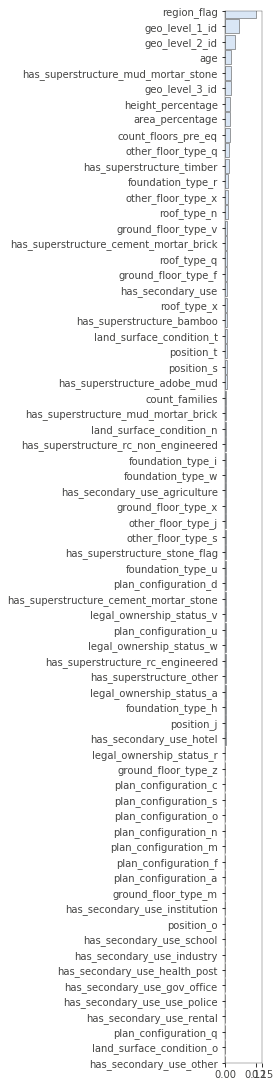

In [16]:
imp = importances(model_1, X, y) # permutation
viz = plot_importances(imp)
viz.view()

In [17]:
test_values = clean(test)

In [18]:
y_test_preds = model_1.predict(test_values)

In [19]:
test_vals = clean(test)

In [20]:
#submit(model_, test_vals, 'alansub2')

## Model Improvements

In [27]:
from sklearn.model_selection import RandomizedSearchCV

In [28]:
X = pd.read_csv('../data/train_values.csv')
y = pd.read_csv('../data/train_labels.csv')['damage_grade']

In [29]:
# flags from geo_level_3_id
high_damage_region = [0, 1, 6, 12, 13, 15, 23, 44, 54, 55, 61, 68, 82, 88, 94, 97, 103, 108, 109, 112, 116, 119, 125, 133, 135, 136, 139, 140, 150, 152, 157, 158, 161, 165, 173, 176, 178, 180, 183, 184, 190, 199, 200, 214, 219, 220, 222, 223, 245, 253, 255, 259, 264, 273, 277, 283, 301, 304, 307, 310, 316, 319, 325, 330, 331, 338, 344, 345, 349, 358, 382, 386, 392, 401, 403, 407, 415, 417, 420, 422, 425, 426, 433, 435, 439, 442, 450, 452, 456, 457, 458, 465, 466, 469, 472, 477, 479, 480, 482, 483, 487, 491, 498, 499, 505, 508, 510, 522, 526, 527, 528, 539, 542, 548, 550, 552, 560, 562, 563, 569, 571, 574, 576, 582, 584, 600, 602, 607, 609, 610, 615, 619, 625, 632, 634, 636, 637, 644, 645, 648, 656, 672, 675, 678, 689, 690, 691, 693, 696, 698, 709, 716, 721, 722, 728, 731, 736, 737, 740, 752, 759, 761, 763, 770, 776, 783, 784, 786, 787, 788, 796, 804, 812, 813, 817, 819, 822, 824, 828, 830, 831, 835, 836, 839, 840, 844, 848, 849, 862, 864, 867, 896, 907, 908, 910, 924, 931, 938, 939, 940, 956, 957, 958, 960, 963, 968, 974, 975, 977, 978, 983, 984, 1002, 1005, 1009, 1010, 1013, 1015, 1021, 1034, 1038, 1039, 1043, 1054, 1055, 1056, 1058, 1059, 1069, 1071, 1074, 1079, 1088, 1095, 1108, 1110, 1112, 1113, 1119, 1121, 1128, 1132, 1134, 1137, 1159, 1160, 1167, 1181, 1183, 1184, 1191, 1192, 1197, 1206, 1208, 1209, 1225, 1227, 1228, 1229, 1231, 1234, 1239, 1241, 1249, 1253, 1254, 1257, 1265, 1274, 1279, 1282, 1284, 1295, 1303, 1304, 1315, 1325, 1326, 1333, 1338, 1340, 1342, 1346, 1347, 1349, 1351, 1366, 1377, 1382, 1385, 1390, 1394, 1396, 1397, 1400, 1404, 1405, 1408, 1411, 1415, 1426, 1429, 1430, 1434, 1439, 1440, 1442, 1443, 1446, 1450, 1458, 1460, 1462, 1468, 1473, 1484, 1486, 1494, 1495, 1496, 1497, 1499, 1505, 1510, 1513, 1514, 1515, 1517, 1524, 1525, 1529, 1535, 1541, 1557, 1563, 1567, 1576, 1596, 1598, 1601, 1606, 1614, 1622, 1628, 1629, 1634, 1635, 1648, 1662, 1666, 1679, 1680, 1685, 1687, 1688, 1701, 1703, 1709, 1723, 1728, 1729, 1743, 1744, 1751, 1755, 1770, 1772, 1775, 1779, 1791, 1792, 1793, 1794, 1798, 1803, 1811, 1812, 1819, 1824, 1832, 1833, 1834, 1835, 1837, 1839, 1843, 1844, 1845, 1849, 1869, 1871, 1875, 1878, 1881, 1882, 1895, 1896, 1898, 1902, 1905, 1914, 1921, 1936, 1940, 1941, 1948, 1949, 1954, 1956, 1959, 1960, 1966, 1967, 1973, 1979, 1981, 1982, 1989, 1990, 1996, 2001, 2003, 2009, 2010, 2011, 2012, 2013, 2018, 2022, 2027, 2028, 2033, 2038, 2041, 2043, 2045, 2051, 2052, 2054, 2056, 2060, 2069, 2075, 2081, 2082, 2090, 2097, 2100, 2109, 2110, 2114, 2122, 2126, 2127, 2131, 2132, 2141, 2148, 2149, 2154, 2166, 2167, 2169, 2172, 2177, 2178, 2181, 2187, 2192, 2198, 2200, 2201, 2202, 2203, 2206, 2211, 2213, 2214, 2216, 2221, 2231, 2237, 2239, 2243, 2249, 2256, 2257, 2263, 2265, 2267, 2271, 2280, 2288, 2290, 2293, 2309, 2311, 2313, 2319, 2322, 2327, 2329, 2330, 2332, 2333, 2339, 2346, 2347, 2348, 2364, 2366, 2377, 2382, 2383, 2386, 2388, 2392, 2397, 2398, 2400, 2402, 2408, 2420, 2421, 2425, 2427, 2428, 2431, 2434, 2436, 2438, 2439, 2442, 2448, 2458, 2462, 2464, 2466, 2475, 2487, 2488, 2490, 2508, 2513, 2517, 2522, 2532, 2534, 2536, 2538, 2541, 2550, 2552, 2553, 2560, 2565, 2568, 2584, 2588, 2591, 2595, 2600, 2605, 2611, 2620, 2621, 2629, 2635, 2638, 2639, 2642, 2643, 2670, 2675, 2677, 2679, 2684, 2686, 2687, 2691, 2693, 2695, 2708, 2718, 2723, 2724, 2729, 2731, 2732, 2737, 2740, 2744, 2746, 2752, 2755, 2758, 2759, 2762, 2764, 2767, 2774, 2784, 2785, 2786, 2793, 2795, 2796, 2801, 2804, 2805, 2808, 2809, 2813, 2816, 2820, 2821, 2832, 2835, 2836, 2845, 2847, 2860, 2866, 2868, 2872, 2878, 2882, 2884, 2886, 2887, 2890, 2897, 2901, 2904, 2906, 2910, 2911, 2915, 2946, 2947, 2948, 2951, 2954, 2956, 2958, 2960, 2962, 2963, 2968, 2972, 2980, 2981, 2984, 2985, 2989, 2990, 2997, 3004, 3009, 3013, 3014, 3017, 3018, 3020, 3022, 3025, 3027, 3039, 3055, 3056, 3060, 3066, 3070, 3083, 3085, 3090, 3091, 3102, 3112, 3113, 3115, 3119, 3123, 3129, 3132, 3142, 3148, 3159, 3161, 3175, 3183, 3193, 3197, 3199, 3200, 3203, 3217, 3219, 3222, 3224, 3225, 3230, 3235, 3238, 3246, 3249, 3250, 3257, 3261, 3262, 3265, 3266, 3267, 3268, 3269, 3270, 3276, 3278, 3280, 3282, 3283, 3285, 3290, 3296, 3297, 3298, 3301, 3303, 3304, 3306, 3310, 3314, 3316, 3319, 3325, 3326, 3332, 3335, 3342, 3344, 3350, 3352, 3353, 3362, 3363, 3364, 3367, 3381, 3387, 3389, 3390, 3397, 3403, 3405, 3407, 3417, 3423, 3424, 3428, 3430, 3431, 3432, 3434, 3438, 3441, 3444, 3450, 3454, 3456, 3457, 3461, 3462, 3467, 3472, 3474, 3485, 3490, 3491, 3493, 3497, 3498, 3501, 3502, 3507, 3510, 3523, 3533, 3537, 3543, 3546, 3547, 3550, 3552, 3560, 3561, 3566, 3576, 3577, 3581, 3587, 3595, 3598, 3599, 3603, 3606, 3616, 3617, 3618, 3619, 3621, 3629, 3631, 3632, 3634, 3638, 3639, 3655, 3659, 3663, 3664, 3665, 3668, 3670, 3675, 3683, 3687, 3689, 3694, 3708, 3709, 3711, 3713, 3719, 3720, 3721, 3733, 3735, 3737, 3740, 3744, 3749, 3754, 3755, 3772, 3774, 3792, 3797, 3802, 3806, 3809, 3814, 3815, 3817, 3819, 3820, 3825, 3830, 3836, 3839, 3840, 3842, 3844, 3845, 3848, 3856, 3864, 3865, 3875, 3876, 3877, 3881, 3889, 3894, 3895, 3897, 3915, 3916, 3920, 3926, 3935, 3943, 3944, 3950, 3953, 3962, 3974, 3978, 3979, 3981, 3982, 3994, 3995, 3996, 3999, 4004, 4006, 4015, 4017, 4021, 4023, 4027, 4032, 4036, 4038, 4042, 4044, 4045, 4053, 4059, 4061, 4065, 4070, 4076, 4079, 4086, 4087, 4088, 4091, 4094, 4101, 4104, 4116, 4118, 4119, 4121, 4135, 4149, 4151, 4154, 4157, 4159, 4160, 4164, 4166, 4168, 4169, 4173, 4174, 4187, 4188, 4197, 4201, 4205, 4206, 4210, 4213, 4216, 4219, 4221, 4222, 4224, 4226, 4231, 4241, 4247, 4253, 4254, 4255, 4257, 4258, 4259, 4260, 4261, 4262, 4271, 4273, 4278, 4289, 4290, 4292, 4296, 4300, 4304, 4314, 4315, 4321, 4325, 4330, 4335, 4336, 4343, 4348, 4356, 4358, 4359, 4362, 4364, 4371, 4372, 4373, 4378, 4382, 4383, 4384, 4386, 4387, 4390, 4391, 4392, 4393, 4396, 4403, 4404, 4408, 4409, 4421, 4423, 4425, 4430, 4434, 4437, 4440, 4452, 4463, 4469, 4475, 4476, 4481, 4482, 4485, 4495, 4498, 4501, 4503, 4506, 4511, 4518, 4521, 4527, 4533, 4534, 4536, 4546, 4551, 4563, 4566, 4576, 4579, 4584, 4586, 4590, 4591, 4594, 4595, 4597, 4599, 4600, 4602, 4606, 4611, 4619, 4621, 4646, 4657, 4664, 4666, 4667, 4677, 4682, 4690, 4705, 4706, 4710, 4712, 4714, 4724, 4727, 4730, 4731, 4734, 4736, 4737, 4741, 4743, 4747, 4748, 4752, 4765, 4775, 4784, 4786, 4800, 4802, 4809, 4813, 4814, 4820, 4826, 4827, 4829, 4830, 4843, 4844, 4850, 4853, 4855, 4860, 4861, 4869, 4877, 4880, 4883, 4884, 4887, 4888, 4892, 4894, 4900, 4910, 4917, 4918, 4923, 4928, 4929, 4936, 4940, 4946, 4948, 4949, 4952, 4953, 4960, 4961, 4963, 4967, 4969, 4972, 4975, 4979, 4982, 4986, 4989, 4992, 5000, 5001, 5006, 5009, 5026, 5029, 5032, 5035, 5037, 5038, 5043, 5046, 5047, 5049, 5053, 5061, 5062, 5067, 5070, 5072, 5077, 5083, 5084, 5085, 5086, 5087, 5089, 5091, 5092, 5094, 5096, 5097, 5107, 5109, 5114, 5115, 5123, 5126, 5133, 5136, 5139, 5152, 5154, 5156, 5164, 5167, 5172, 5175, 5178, 5179, 5182, 5190, 5195, 5198, 5202, 5205, 5206, 5208, 5209, 5214, 5220, 5221, 5222, 5230, 5237, 5239, 5240, 5242, 5246, 5247, 5250, 5252, 5257, 5268, 5276, 5290, 5304, 5305, 5306, 5308, 5311, 5315, 5317, 5324, 5325, 5342, 5345, 5347, 5359, 5364, 5365, 5370, 5371, 5375, 5376, 5382, 5403, 5408, 5416, 5425, 5426, 5428, 5435, 5439, 5443, 5445, 5450, 5455, 5459, 5465, 5468, 5476, 5477, 5480, 5483, 5487, 5488, 5491, 5496, 5498, 5500, 5501, 5504, 5507, 5509, 5513, 5514, 5520, 5535, 5538, 5541, 5558, 5559, 5561, 5565, 5568, 5575, 5576, 5577, 5584, 5585, 5590, 5592, 5594, 5597, 5605, 5608, 5637, 5640, 5655, 5661, 5662, 5664, 5673, 5679, 5684, 5685, 5706, 5708, 5710, 5713, 5714, 5716, 5724, 5726, 5727, 5738, 5741, 5746, 5747, 5749, 5754, 5757, 5758, 5765, 5777, 5781, 5800, 5802, 5807, 5808, 5810, 5813, 5815, 5816, 5818, 5832, 5840, 5847, 5849, 5864, 5865, 5871, 5873, 5884, 5887, 5889, 5891, 5895, 5903, 5913, 5916, 5921, 5933, 5936, 5937, 5938, 5939, 5945, 5950, 5957, 5960, 5965, 5968, 5972, 5973, 5979, 5983, 5988, 5993, 5994, 5996, 5997, 6001, 6003, 6007, 6008, 6011, 6014, 6018, 6024, 6026, 6043, 6044, 6048, 6076, 6078, 6081, 6082, 6091, 6094, 6099, 6107, 6108, 6109, 6112, 6120, 6127, 6130, 6132, 6134, 6139, 6140, 6141, 6150, 6162, 6169, 6173, 6174, 6184, 6188, 6192, 6200, 6205, 6206, 6211, 6218, 6222, 6224, 6225, 6234, 6244, 6250, 6251, 6252, 6257, 6260, 6276, 6284, 6285, 6287, 6288, 6289, 6290, 6297, 6298, 6303, 6312, 6314, 6316, 6323, 6330, 6334, 6335, 6339, 6340, 6349, 6350, 6358, 6362, 6370, 6374, 6376, 6382, 6386, 6393, 6396, 6399, 6404, 6407, 6408, 6410, 6412, 6416, 6419, 6424, 6427, 6429, 6434, 6438, 6440, 6448, 6452, 6453, 6454, 6458, 6460, 6467, 6483, 6499, 6508, 6517, 6518, 6523, 6524, 6526, 6533, 6539, 6540, 6544, 6546, 6547, 6550, 6551, 6552, 6553, 6554, 6556, 6557, 6558, 6559, 6560, 6563, 6567, 6569, 6573, 6577, 6585, 6588, 6590, 6598, 6604, 6605, 6606, 6609, 6616, 6619, 6624, 6632, 6637, 6638, 6639, 6641, 6649, 6654, 6661, 6663, 6675, 6677, 6681, 6683, 6688, 6697, 6707, 6713, 6715, 6717, 6728, 6729, 6734, 6744, 6746, 6747, 6757, 6759, 6762, 6766, 6767, 6768, 6770, 6783, 6788, 6797, 6798, 6800, 6803, 6806, 6813, 6814, 6817, 6818, 6822, 6828, 6830, 6839, 6845, 6853, 6855, 6864, 6867, 6872, 6878, 6880, 6885, 6894, 6902, 6912, 6913, 6914, 6915, 6917, 6921, 6925, 6927, 6935, 6936, 6938, 6939, 6940, 6943, 6944, 6945, 6948, 6960, 6965, 6969, 6981, 6988, 6989, 6997, 6998, 7009, 7014, 7018, 7024, 7027, 7036, 7037, 7038, 7039, 7043, 7051, 7052, 7056, 7059, 7066, 7074, 7075, 7076, 7082, 7086, 7087, 7088, 7089, 7093, 7095, 7096, 7098, 7108, 7109, 7110, 7114, 7120, 7123, 7125, 7135, 7136, 7137, 7139, 7142, 7143, 7146, 7152, 7157, 7160, 7171, 7175, 7176, 7194, 7195, 7197, 7205, 7218, 7220, 7230, 7233, 7239, 7246, 7251, 7253, 7254, 7255, 7257, 7261, 7265, 7269, 7272, 7273, 7278, 7281, 7284, 7286, 7289, 7293, 7297, 7299, 7305, 7310, 7322, 7328, 7330, 7332, 7333, 7334, 7337, 7341, 7344, 7353, 7354, 7357, 7373, 7374, 7375, 7377, 7378, 7383, 7395, 7404, 7406, 7407, 7411, 7414, 7436, 7439, 7445, 7450, 7453, 7456, 7461, 7469, 7477, 7487, 7491, 7498, 7502, 7504, 7507, 7512, 7521, 7523, 7530, 7534, 7538, 7540, 7541, 7546, 7547, 7548, 7550, 7555, 7559, 7560, 7564, 7565, 7566, 7570, 7575, 7576, 7577, 7590, 7591, 7592, 7594, 7601, 7606, 7609, 7610, 7616, 7623, 7625, 7627, 7629, 7635, 7637, 7639, 7647, 7658, 7664, 7675, 7680, 7685, 7689, 7694, 7697, 7700, 7703, 7704, 7705, 7707, 7718, 7727, 7728, 7729, 7730, 7737, 7740, 7756, 7766, 7772, 7776, 7782, 7784, 7786, 7789, 7798, 7799, 7801, 7803, 7804, 7805, 7807, 7814, 7817, 7820, 7821, 7836, 7840, 7841, 7842, 7845, 7851, 7863, 7864, 7881, 7882, 7886, 7887, 7897, 7900, 7907, 7909, 7914, 7932, 7935, 7951, 7957, 7960, 7961, 7970, 7972, 7973, 7986, 7988, 7990, 7992, 7997, 8001, 8002, 8003, 8005, 8006, 8011, 8025, 8031, 8032, 8036, 8040, 8049, 8050, 8053, 8057, 8059, 8060, 8069, 8070, 8088, 8091, 8094, 8103, 8105, 8108, 8112, 8116, 8118, 8130, 8134, 8135, 8138, 8143, 8148, 8153, 8159, 8160, 8163, 8169, 8182, 8187, 8189, 8194, 8196, 8198, 8200, 8204, 8213, 8215, 8217, 8222, 8223, 8224, 8225, 8226, 8227, 8231, 8232, 8235, 8239, 8248, 8249, 8250, 8256, 8263, 8269, 8275, 8277, 8283, 8284, 8288, 8291, 8309, 8311, 8312, 8316, 8317, 8324, 8325, 8326, 8327, 8329, 8330, 8331, 8333, 8339, 8342, 8348, 8350, 8351, 8359, 8365, 8366, 8371, 8372, 8373, 8380, 8382, 8383, 8388, 8390, 8395, 8396, 8398, 8399, 8404, 8406, 8415, 8416, 8424, 8429, 8431, 8434, 8437, 8438, 8439, 8440, 8441, 8443, 8448, 8451, 8456, 8459, 8463, 8467, 8468, 8469, 8473, 8474, 8475, 8476, 8483, 8488, 8490, 8497, 8501, 8505, 8508, 8512, 8513, 8514, 8522, 8535, 8542, 8549, 8550, 8555, 8564, 8570, 8571, 8579, 8591, 8592, 8595, 8597, 8607, 8621, 8623, 8625, 8626, 8628, 8631, 8632, 8635, 8644, 8651, 8653, 8656, 8666, 8667, 8671, 8673, 8685, 8688, 8691, 8695, 8706, 8708, 8709, 8714, 8716, 8718, 8721, 8724, 8726, 8731, 8732, 8734, 8737, 8738, 8739, 8743, 8751, 8755, 8764, 8769, 8772, 8778, 8783, 8784, 8785, 8786, 8788, 8793, 8796, 8798, 8801, 8806, 8812, 8814, 8818, 8825, 8828, 8835, 8837, 8838, 8840, 8847, 8858, 8860, 8861, 8862, 8866, 8871, 8877, 8882, 8886, 8889, 8890, 8899, 8914, 8915, 8918, 8921, 8923, 8924, 8925, 8927, 8929, 8930, 8939, 8950, 8960, 8963, 8966, 8969, 8973, 8975, 8979, 8981, 8983, 8984, 8986, 8987, 8993, 8998, 9010, 9012, 9014, 9017, 9022, 9023, 9026, 9037, 9038, 9041, 9044, 9054, 9061, 9065, 9066, 9070, 9071, 9072, 9075, 9078, 9101, 9104, 9108, 9112, 9115, 9121, 9138, 9142, 9145, 9146, 9154, 9155, 9157, 9159, 9160, 9162, 9172, 9178, 9180, 9181, 9187, 9192, 9198, 9209, 9213, 9217, 9219, 9220, 9222, 9223, 9225, 9232, 9237, 9238, 9240, 9248, 9250, 9256, 9260, 9264, 9273, 9274, 9275, 9277, 9283, 9287, 9288, 9289, 9299, 9301, 9305, 9307, 9309, 9310, 9317, 9318, 9322, 9323, 9325, 9327, 9328, 9330, 9333, 9334, 9338, 9339, 9357, 9358, 9360, 9362, 9364, 9365, 9366, 9370, 9376, 9378, 9381, 9388, 9390, 9391, 9398, 9403, 9405, 9408, 9412, 9414, 9416, 9419, 9421, 9423, 9424, 9432, 9433, 9437, 9439, 9453, 9455, 9460, 9465, 9466, 9469, 9471, 9475, 9476, 9483, 9486, 9487, 9489, 9497, 9500, 9507, 9510, 9514, 9516, 9517, 9519, 9524, 9525, 9528, 9532, 9534, 9540, 9541, 9543, 9546, 9549, 9554, 9560, 9563, 9567, 9574, 9577, 9586, 9587, 9595, 9596, 9598, 9603, 9626, 9629, 9631, 9640, 9641, 9644, 9653, 9654, 9657, 9662, 9666, 9682, 9684, 9685, 9703, 9705, 9709, 9710, 9711, 9713, 9721, 9727, 9731, 9732, 9735, 9736, 9740, 9744, 9748, 9751, 9754, 9767, 9770, 9775, 9776, 9786, 9787, 9795, 9797, 9802, 9803, 9805, 9808, 9810, 9814, 9815, 9816, 9821, 9839, 9840, 9841, 9845, 9849, 9855, 9860, 9867, 9870, 9880, 9884, 9887, 9894, 9895, 9896, 9898, 9901, 9903, 9905, 9907, 9908, 9912, 9913, 9918, 9919, 9923, 9925, 9931, 9932, 9934, 9935, 9942, 9944, 9950, 9954, 9959, 9961, 9966, 9967, 9968, 9974, 9977, 9985, 9986, 9988, 9990, 9994, 9995, 9997, 9999, 10002, 10005, 10026, 10031, 10033, 10035, 10038, 10043, 10044, 10047, 10052, 10054, 10058, 10060, 10066, 10074, 10075, 10076, 10079, 10080, 10081, 10086, 10088, 10090, 10092, 10095, 10101, 10103, 10106, 10125, 10129, 10132, 10133, 10135, 10150, 10155, 10156, 10157, 10164, 10165, 10171, 10173, 10187, 10191, 10196, 10200, 10204, 10210, 10227, 10232, 10233, 10234, 10239, 10241, 10245, 10247, 10251, 10253, 10256, 10257, 10258, 10261, 10278, 10284, 10291, 10293, 10296, 10302, 10313, 10315, 10320, 10328, 10331, 10334, 10345, 10355, 10356, 10358, 10361, 10362, 10365, 10370, 10372, 10379, 10382, 10385, 10386, 10391, 10392, 10394, 10406, 10412, 10415, 10426, 10428, 10440, 10448, 10450, 10453, 10462, 10464, 10470, 10471, 10497, 10499, 10505, 10506, 10509, 10512, 10522, 10528, 10529, 10532, 10538, 10541, 10551, 10560, 10561, 10566, 10568, 10572, 10575, 10577, 10580, 10592, 10599, 10600, 10602, 10606, 10611, 10612, 10613, 10614, 10617, 10622, 10637, 10639, 10641, 10649, 10654, 10666, 10667, 10669, 10684, 10699, 10700, 10707, 10712, 10718, 10719, 10720, 10723, 10726, 10735, 10739, 10743, 10744, 10748, 10762, 10765, 10770, 10771, 10774, 10777, 10779, 10783, 10787, 10792, 10799, 10805, 10819, 10821, 10833, 10834, 10835, 10836, 10843, 10844, 10848, 10855, 10858, 10866, 10869, 10871, 10872, 10875, 10876, 10888, 10889, 10891, 10895, 10898, 10908, 10913, 10917, 10919, 10921, 10925, 10927, 10932, 10934, 10935, 10937, 10954, 10958, 10966, 10967, 10968, 10974, 10975, 10978, 10979, 10982, 10984, 10990, 10992, 10994, 11013, 11014, 11016, 11017, 11024, 11026, 11029, 11034, 11035, 11040, 11043, 11046, 11050, 11052, 11060, 11065, 11066, 11075, 11086, 11088, 11089, 11091, 11099, 11100, 11104, 11108, 11116, 11119, 11121, 11125, 11127, 11133, 11135, 11137, 11140, 11141, 11144, 11146, 11147, 11150, 11155, 11167, 11168, 11172, 11175, 11182, 11185, 11186, 11191, 11192, 11197, 11198, 11200, 11208, 11210, 11221, 11224, 11226, 11229, 11234, 11239, 11240, 11252, 11257, 11264, 11267, 11269, 11273, 11276, 11277, 11282, 11284, 11292, 11295, 11299, 11300, 11305, 11307, 11311, 11312, 11318, 11322, 11329, 11333, 11335, 11344, 11346, 11352, 11353, 11366, 11369, 11374, 11380, 11381, 11382, 11385, 11391, 11393, 11396, 11398, 11407, 11412, 11419, 11420, 11421, 11424, 11429, 11433, 11434, 11436, 11449, 11451, 11452, 11453, 11455, 11456, 11458, 11465, 11466, 11467, 11471, 11475, 11476, 11481, 11482, 11485, 11488, 11490, 11497, 11509, 11514, 11523, 11526, 11531, 11532, 11543, 11544, 11548, 11550, 11553, 11560, 11570, 11578, 11579, 11580, 11582, 11587, 11589, 11591, 11595, 11599, 11609, 11612, 11615, 11616, 11618, 11620, 11631, 11634, 11637, 11643, 11645, 11649, 11652, 11657, 11667, 11673, 11674, 11675, 11680, 11685, 11687, 11691, 11692, 11703, 11714, 11730, 11731, 11745, 11749, 11750, 11770, 11772, 11774, 11779, 11788, 11790, 11792, 11804, 11808, 11814, 11816, 11817, 11822, 11823, 11824, 11825, 11837, 11838, 11839, 11840, 11841, 11843, 11847, 11857, 11858, 11862, 11863, 11865, 11867, 11870, 11873, 11880, 11882, 11883, 11884, 11887, 11889, 11890, 11902, 11905, 11906, 11907, 11920, 11923, 11924, 11927, 11930, 11932, 11933, 11938, 11940, 11941, 11957, 11958, 11961, 11962, 11977, 11979, 11982, 11998, 12000, 12007, 12008, 12011, 12012, 12013, 12014, 12019, 12020, 12023, 12025, 12049, 12050, 12051, 12054, 12057, 12066, 12082, 12088, 12091, 12092, 12093, 12094, 12096, 12099, 12100, 12105, 12109, 12115, 12116, 12119, 12124, 12125, 12128, 12130, 12136, 12140, 12142, 12145, 12146, 12162, 12174, 12175, 12176, 12182, 12188, 12189, 12192, 12197, 12198, 12209, 12210, 12212, 12216, 12218, 12219, 12224, 12227, 12243, 12248, 12249, 12254, 12265, 12270, 12272, 12275, 12276, 12277, 12281, 12282, 12283, 12288, 12293, 12295, 12299, 12301, 12309, 12318, 12321, 12322, 12328, 12329, 12336, 12340, 12346, 12348, 12349, 12353, 12359, 12362, 12369, 12383, 12385, 12387, 12390, 12396, 12398, 12403, 12404, 12414, 12416, 12422, 12425, 12427, 12428, 12431, 12435, 12439, 12440, 12446, 12462, 12465, 12468, 12474, 12499, 12500, 12502, 12503, 12506, 12507, 12508, 12510, 12519, 12524, 12525, 12538, 12540, 12541, 12542, 12551, 12557]
low_damage_region = [5, 2, 34, 39, 66, 93, 96, 147, 179, 195, 208, 240, 246, 293, 356, 385, 418, 428, 434, 453, 461, 468, 496, 503, 531, 572, 583, 633, 667, 712, 732, 747, 767, 772, 773, 875, 884, 891, 979, 992, 1020, 1022, 1044, 1051, 1086, 1125, 1138, 1140, 1157, 1189, 1204, 1324, 1327, 1378, 1401, 1407, 1420, 1441, 1444, 1465, 1478, 1487, 1522, 1607, 1670, 1676, 1684, 1699, 1700, 1740, 1759, 1761, 1768, 1805, 1817, 1848, 1850, 1864, 1866, 1911, 1917, 1919, 1930, 1968, 1978, 2036, 2062, 2083, 2093, 2094, 2227, 2261, 2266, 2292, 2338, 2360, 2418, 2422, 2449, 2473, 2555, 2566, 2583, 2598, 2615, 2619, 2645, 2671, 2688, 2700, 2748, 2768, 2798, 2833, 2846, 2849, 2902, 2905, 2953, 2994, 2996, 3059, 3073, 3079, 3152, 3221, 3233, 3259, 3284, 3339, 3341, 3476, 3478, 3494, 3548, 3607, 3643, 3647, 3667, 3674, 3718, 3743, 3756, 3765, 3783, 3788, 3857, 3867, 3929, 3942, 4010, 4050, 4056, 4064, 4071, 4115, 4207, 4215, 4217, 4238, 4248, 4277, 4326, 4351, 4370, 4381, 4388, 4401, 4420, 4431, 4433, 4491, 4542, 4564, 4607, 4638, 4641, 4660, 4693, 4732, 4768, 4792, 4812, 4885, 4927, 4947, 4954, 4970, 5023, 5040, 5051, 5054, 5082, 5108, 5165, 5189, 5233, 5260, 5263, 5309, 5313, 5314, 5318, 5336, 5386, 5399, 5452, 5471, 5518, 5534, 5536, 5601, 5604, 5620, 5632, 5649, 5653, 5665, 5703, 5819, 5828, 5846, 5876, 5879, 5881, 5906, 5955, 6012, 6031, 6055, 6075, 6101, 6117, 6187, 6199, 6215, 6229, 6258, 6366, 6377, 6392, 6443, 6484, 6486, 6535, 6555, 6562, 6570, 6579, 6612, 6617, 6626, 6643, 6660, 6694, 6706, 6784, 6847, 6865, 6870, 6884, 6937, 6955, 6982, 7006, 7034, 7042, 7058, 7101, 7248, 7263, 7321, 7325, 7335, 7336, 7363, 7430, 7438, 7449, 7457, 7460, 7479, 7490, 7503, 7615, 7630, 7662, 7665, 7690, 7715, 7723, 7754, 7788, 7794, 7819, 7885, 7927, 7933, 7936, 7999, 8022, 8041, 8051, 8072, 8092, 8124, 8144, 8271, 8318, 8334, 8357, 8374, 8403, 8518, 8520, 8603, 8654, 8668, 8677, 8684, 8699, 8707, 8735, 8759, 8789, 8824, 8829, 8836, 8839, 8919, 8932, 8940, 8945, 8951, 8965, 9085, 9107, 9109, 9120, 9127, 9133, 9149, 9151, 9161, 9165, 9170, 9195, 9203, 9214, 9234, 9266, 9290, 9293, 9294, 9296, 9373, 9384, 9411, 9428, 9434, 9557, 9566, 9572, 9648, 9698, 9779, 9807, 9852, 9881, 9915, 9964, 9978, 9982, 9983, 10012, 10020, 10136, 10176, 10190, 10193, 10215, 10254, 10263, 10316, 10317, 10323, 10329, 10347, 10348, 10373, 10390, 10459, 10485, 10518, 10581, 10676, 10747, 10778, 10831, 10896, 10903, 10942, 10945, 10963, 10998, 11048, 11054, 11056, 11068, 11076, 11123, 11187, 11193, 11194, 11206, 11214, 11231, 11249, 11256, 11260, 11338, 11355, 11376, 11389, 11447, 11459, 11506, 11551, 11590, 11604, 11617, 11619, 11640, 11654, 11658, 11661, 11670, 11718, 11723, 11737, 11800, 11849, 11859, 11879, 11939, 11983, 12009, 12022, 12046, 12058, 12061, 12076, 12170, 12236, 12274, 12278, 12302, 12317, 12335, 12339, 12350, 12379, 12407, 12408, 12424, 12437, 12454, 12455, 12467, 12476, 12483, 12485, 12492, 12545, 12565]

In [30]:
def clean2(X):
    X = X.drop(['building_id', 'has_superstructure_rc_engineered', 'has_secondary_use_rental',
                'has_secondary_use_use_police', 'has_secondary_use_gov_office', 'has_secondary_use_health_post',
                'has_secondary_use_industry', 'has_secondary_use_school'], axis=1)
    X['region_flag'] = 1
    X.loc[X.geo_level_3_id.isin(low_damage_region), 'region_flag'] = 0
    X.loc[X.geo_level_3_id.isin(high_damage_region), 'region_flag'] = 2
    X = pd.get_dummies(X)
    return X

In [31]:
X_ = clean2(X)

In [32]:
rf = RandomForestClassifier()
params = {'n_estimators': [50, 100, 150, 200],
         'criterion': ['gini', 'entropy'],
         'min_samples_leaf': [3, 5, 10, 25],
         'max_features': ['sqrt', 'log2']}
n_iter = 7

In [33]:
rand_rf = RandomizedSearchCV(rf, param_distributions=params, scoring='f1_micro', n_iter=n_iter, cv=5, 
                             n_jobs=-1, verbose=1)

In [35]:
rand_rf.fit(X_, y)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  5.2min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [36]:
rand_rf.cv_results_

{'mean_fit_time': array([ 90.1511775 , 162.59258819,  24.9454812 ,  93.60691166,
         49.25802956,  29.60606041,  16.90257478]),
 'std_fit_time': array([0.42663935, 6.65004747, 1.1659478 , 2.5306539 , 1.63360364,
        0.3056109 , 3.82375819]),
 'mean_score_time': array([3.81386371, 6.15424957, 0.93620715, 3.86764135, 1.92077341,
        1.1967464 , 0.64636893]),
 'std_score_time': array([0.06877822, 0.15916988, 0.02136871, 0.54581046, 0.20863756,
        0.11044716, 0.2089458 ]),
 'param_n_estimators': masked_array(data=[150, 200, 50, 150, 100, 50, 50],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[3, 3, 25, 5, 25, 5, 25],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=['log2', 'sqrt', 'log2', 'log2', 'log2', 'log2', 'log2'],
              mask=

In [37]:
rand_rf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [38]:
rand_rf.best_params_

{'n_estimators': 200,
 'min_samples_leaf': 3,
 'max_features': 'sqrt',
 'criterion': 'gini'}

In [146]:
#### 

In [40]:
X_ = clean2(X)

In [41]:
model = RandomForestClassifier(n_estimators=200, min_samples_leaf=3, oob_score=True, verbose=1, n_jobs=-1)

In [42]:
model.fit(X_,y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   21.7s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=1,
                       warm_start=False)

In [43]:
model.oob_score_

0.7478290566805192

In [44]:
imp = importances(model, X_, y) # permutation

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      |

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      |

[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished


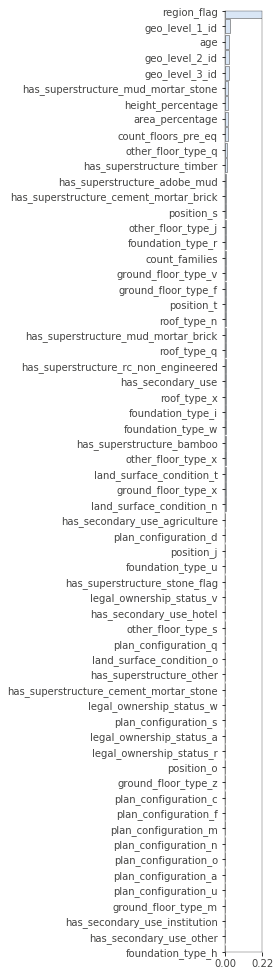

In [46]:
viz = plot_importances(imp)
viz.view()

In [47]:
# region flag suspiciously important, probably too much so
imp.index

Index(['region_flag', 'geo_level_1_id', 'age', 'geo_level_2_id',
       'geo_level_3_id', 'has_superstructure_mud_mortar_stone',
       'height_percentage', 'area_percentage', 'count_floors_pre_eq',
       'other_floor_type_q', 'has_superstructure_timber',
       'has_superstructure_adobe_mud',
       'has_superstructure_cement_mortar_brick', 'position_s',
       'other_floor_type_j', 'foundation_type_r', 'count_families',
       'ground_floor_type_v', 'ground_floor_type_f', 'position_t',
       'roof_type_n', 'has_superstructure_mud_mortar_brick', 'roof_type_q',
       'has_superstructure_rc_non_engineered', 'has_secondary_use',
       'roof_type_x', 'foundation_type_i', 'foundation_type_w',
       'has_superstructure_bamboo', 'other_floor_type_x',
       'land_surface_condition_t', 'ground_floor_type_x',
       'land_surface_condition_n', 'has_secondary_use_agriculture',
       'plan_configuration_d', 'position_j', 'foundation_type_u',
       'has_superstructure_stone_flag', 'legal_o

In [48]:
kfold(model, X_, y, k=5)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   19.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   19.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 task

[0.751539686498724,
 0.7471028396009209,
 0.7449923254029164,
 0.748254029163469,
 0.744205679201842]

In [49]:
#test_v = clean2(test)

In [50]:
#submit(model, test_v, 'alansub4')

# Model w Density and Damage

In [51]:
X = pd.read_csv('../data/train_values.csv')
y = pd.read_csv('../data/train_labels.csv')['damage_grade']
test = pd.read_csv('../data/test_values.csv')

In [52]:
high_damage_region = [0, 1, 6, 12, 13, 15, 23, 44, 54, 55, 61, 68, 82, 88, 94, 97, 103, 108, 109, 112, 116, 119, 125, 133, 135, 136, 139, 140, 150, 152, 157, 158, 161, 165, 173, 176, 178, 180, 183, 184, 190, 199, 200, 214, 219, 220, 222, 223, 245, 253, 255, 259, 264, 273, 277, 283, 301, 304, 307, 310, 316, 319, 325, 330, 331, 338, 344, 345, 349, 358, 382, 386, 392, 401, 403, 407, 415, 417, 420, 422, 425, 426, 433, 435, 439, 442, 450, 452, 456, 457, 458, 465, 466, 469, 472, 477, 479, 480, 482, 483, 487, 491, 498, 499, 505, 508, 510, 522, 526, 527, 528, 539, 542, 548, 550, 552, 560, 562, 563, 569, 571, 574, 576, 582, 584, 600, 602, 607, 609, 610, 615, 619, 625, 632, 634, 636, 637, 644, 645, 648, 656, 672, 675, 678, 689, 690, 691, 693, 696, 698, 709, 716, 721, 722, 728, 731, 736, 737, 740, 752, 759, 761, 763, 770, 776, 783, 784, 786, 787, 788, 796, 804, 812, 813, 817, 819, 822, 824, 828, 830, 831, 835, 836, 839, 840, 844, 848, 849, 862, 864, 867, 896, 907, 908, 910, 924, 931, 938, 939, 940, 956, 957, 958, 960, 963, 968, 974, 975, 977, 978, 983, 984, 1002, 1005, 1009, 1010, 1013, 1015, 1021, 1034, 1038, 1039, 1043, 1054, 1055, 1056, 1058, 1059, 1069, 1071, 1074, 1079, 1088, 1095, 1108, 1110, 1112, 1113, 1119, 1121, 1128, 1132, 1134, 1137, 1159, 1160, 1167, 1181, 1183, 1184, 1191, 1192, 1197, 1206, 1208, 1209, 1225, 1227, 1228, 1229, 1231, 1234, 1239, 1241, 1249, 1253, 1254, 1257, 1265, 1274, 1279, 1282, 1284, 1295, 1303, 1304, 1315, 1325, 1326, 1333, 1338, 1340, 1342, 1346, 1347, 1349, 1351, 1366, 1377, 1382, 1385, 1390, 1394, 1396, 1397, 1400, 1404, 1405, 1408, 1411, 1415, 1426, 1429, 1430, 1434, 1439, 1440, 1442, 1443, 1446, 1450, 1458, 1460, 1462, 1468, 1473, 1484, 1486, 1494, 1495, 1496, 1497, 1499, 1505, 1510, 1513, 1514, 1515, 1517, 1524, 1525, 1529, 1535, 1541, 1557, 1563, 1567, 1576, 1596, 1598, 1601, 1606, 1614, 1622, 1628, 1629, 1634, 1635, 1648, 1662, 1666, 1679, 1680, 1685, 1687, 1688, 1701, 1703, 1709, 1723, 1728, 1729, 1743, 1744, 1751, 1755, 1770, 1772, 1775, 1779, 1791, 1792, 1793, 1794, 1798, 1803, 1811, 1812, 1819, 1824, 1832, 1833, 1834, 1835, 1837, 1839, 1843, 1844, 1845, 1849, 1869, 1871, 1875, 1878, 1881, 1882, 1895, 1896, 1898, 1902, 1905, 1914, 1921, 1936, 1940, 1941, 1948, 1949, 1954, 1956, 1959, 1960, 1966, 1967, 1973, 1979, 1981, 1982, 1989, 1990, 1996, 2001, 2003, 2009, 2010, 2011, 2012, 2013, 2018, 2022, 2027, 2028, 2033, 2038, 2041, 2043, 2045, 2051, 2052, 2054, 2056, 2060, 2069, 2075, 2081, 2082, 2090, 2097, 2100, 2109, 2110, 2114, 2122, 2126, 2127, 2131, 2132, 2141, 2148, 2149, 2154, 2166, 2167, 2169, 2172, 2177, 2178, 2181, 2187, 2192, 2198, 2200, 2201, 2202, 2203, 2206, 2211, 2213, 2214, 2216, 2221, 2231, 2237, 2239, 2243, 2249, 2256, 2257, 2263, 2265, 2267, 2271, 2280, 2288, 2290, 2293, 2309, 2311, 2313, 2319, 2322, 2327, 2329, 2330, 2332, 2333, 2339, 2346, 2347, 2348, 2364, 2366, 2377, 2382, 2383, 2386, 2388, 2392, 2397, 2398, 2400, 2402, 2408, 2420, 2421, 2425, 2427, 2428, 2431, 2434, 2436, 2438, 2439, 2442, 2448, 2458, 2462, 2464, 2466, 2475, 2487, 2488, 2490, 2508, 2513, 2517, 2522, 2532, 2534, 2536, 2538, 2541, 2550, 2552, 2553, 2560, 2565, 2568, 2584, 2588, 2591, 2595, 2600, 2605, 2611, 2620, 2621, 2629, 2635, 2638, 2639, 2642, 2643, 2670, 2675, 2677, 2679, 2684, 2686, 2687, 2691, 2693, 2695, 2708, 2718, 2723, 2724, 2729, 2731, 2732, 2737, 2740, 2744, 2746, 2752, 2755, 2758, 2759, 2762, 2764, 2767, 2774, 2784, 2785, 2786, 2793, 2795, 2796, 2801, 2804, 2805, 2808, 2809, 2813, 2816, 2820, 2821, 2832, 2835, 2836, 2845, 2847, 2860, 2866, 2868, 2872, 2878, 2882, 2884, 2886, 2887, 2890, 2897, 2901, 2904, 2906, 2910, 2911, 2915, 2946, 2947, 2948, 2951, 2954, 2956, 2958, 2960, 2962, 2963, 2968, 2972, 2980, 2981, 2984, 2985, 2989, 2990, 2997, 3004, 3009, 3013, 3014, 3017, 3018, 3020, 3022, 3025, 3027, 3039, 3055, 3056, 3060, 3066, 3070, 3083, 3085, 3090, 3091, 3102, 3112, 3113, 3115, 3119, 3123, 3129, 3132, 3142, 3148, 3159, 3161, 3175, 3183, 3193, 3197, 3199, 3200, 3203, 3217, 3219, 3222, 3224, 3225, 3230, 3235, 3238, 3246, 3249, 3250, 3257, 3261, 3262, 3265, 3266, 3267, 3268, 3269, 3270, 3276, 3278, 3280, 3282, 3283, 3285, 3290, 3296, 3297, 3298, 3301, 3303, 3304, 3306, 3310, 3314, 3316, 3319, 3325, 3326, 3332, 3335, 3342, 3344, 3350, 3352, 3353, 3362, 3363, 3364, 3367, 3381, 3387, 3389, 3390, 3397, 3403, 3405, 3407, 3417, 3423, 3424, 3428, 3430, 3431, 3432, 3434, 3438, 3441, 3444, 3450, 3454, 3456, 3457, 3461, 3462, 3467, 3472, 3474, 3485, 3490, 3491, 3493, 3497, 3498, 3501, 3502, 3507, 3510, 3523, 3533, 3537, 3543, 3546, 3547, 3550, 3552, 3560, 3561, 3566, 3576, 3577, 3581, 3587, 3595, 3598, 3599, 3603, 3606, 3616, 3617, 3618, 3619, 3621, 3629, 3631, 3632, 3634, 3638, 3639, 3655, 3659, 3663, 3664, 3665, 3668, 3670, 3675, 3683, 3687, 3689, 3694, 3708, 3709, 3711, 3713, 3719, 3720, 3721, 3733, 3735, 3737, 3740, 3744, 3749, 3754, 3755, 3772, 3774, 3792, 3797, 3802, 3806, 3809, 3814, 3815, 3817, 3819, 3820, 3825, 3830, 3836, 3839, 3840, 3842, 3844, 3845, 3848, 3856, 3864, 3865, 3875, 3876, 3877, 3881, 3889, 3894, 3895, 3897, 3915, 3916, 3920, 3926, 3935, 3943, 3944, 3950, 3953, 3962, 3974, 3978, 3979, 3981, 3982, 3994, 3995, 3996, 3999, 4004, 4006, 4015, 4017, 4021, 4023, 4027, 4032, 4036, 4038, 4042, 4044, 4045, 4053, 4059, 4061, 4065, 4070, 4076, 4079, 4086, 4087, 4088, 4091, 4094, 4101, 4104, 4116, 4118, 4119, 4121, 4135, 4149, 4151, 4154, 4157, 4159, 4160, 4164, 4166, 4168, 4169, 4173, 4174, 4187, 4188, 4197, 4201, 4205, 4206, 4210, 4213, 4216, 4219, 4221, 4222, 4224, 4226, 4231, 4241, 4247, 4253, 4254, 4255, 4257, 4258, 4259, 4260, 4261, 4262, 4271, 4273, 4278, 4289, 4290, 4292, 4296, 4300, 4304, 4314, 4315, 4321, 4325, 4330, 4335, 4336, 4343, 4348, 4356, 4358, 4359, 4362, 4364, 4371, 4372, 4373, 4378, 4382, 4383, 4384, 4386, 4387, 4390, 4391, 4392, 4393, 4396, 4403, 4404, 4408, 4409, 4421, 4423, 4425, 4430, 4434, 4437, 4440, 4452, 4463, 4469, 4475, 4476, 4481, 4482, 4485, 4495, 4498, 4501, 4503, 4506, 4511, 4518, 4521, 4527, 4533, 4534, 4536, 4546, 4551, 4563, 4566, 4576, 4579, 4584, 4586, 4590, 4591, 4594, 4595, 4597, 4599, 4600, 4602, 4606, 4611, 4619, 4621, 4646, 4657, 4664, 4666, 4667, 4677, 4682, 4690, 4705, 4706, 4710, 4712, 4714, 4724, 4727, 4730, 4731, 4734, 4736, 4737, 4741, 4743, 4747, 4748, 4752, 4765, 4775, 4784, 4786, 4800, 4802, 4809, 4813, 4814, 4820, 4826, 4827, 4829, 4830, 4843, 4844, 4850, 4853, 4855, 4860, 4861, 4869, 4877, 4880, 4883, 4884, 4887, 4888, 4892, 4894, 4900, 4910, 4917, 4918, 4923, 4928, 4929, 4936, 4940, 4946, 4948, 4949, 4952, 4953, 4960, 4961, 4963, 4967, 4969, 4972, 4975, 4979, 4982, 4986, 4989, 4992, 5000, 5001, 5006, 5009, 5026, 5029, 5032, 5035, 5037, 5038, 5043, 5046, 5047, 5049, 5053, 5061, 5062, 5067, 5070, 5072, 5077, 5083, 5084, 5085, 5086, 5087, 5089, 5091, 5092, 5094, 5096, 5097, 5107, 5109, 5114, 5115, 5123, 5126, 5133, 5136, 5139, 5152, 5154, 5156, 5164, 5167, 5172, 5175, 5178, 5179, 5182, 5190, 5195, 5198, 5202, 5205, 5206, 5208, 5209, 5214, 5220, 5221, 5222, 5230, 5237, 5239, 5240, 5242, 5246, 5247, 5250, 5252, 5257, 5268, 5276, 5290, 5304, 5305, 5306, 5308, 5311, 5315, 5317, 5324, 5325, 5342, 5345, 5347, 5359, 5364, 5365, 5370, 5371, 5375, 5376, 5382, 5403, 5408, 5416, 5425, 5426, 5428, 5435, 5439, 5443, 5445, 5450, 5455, 5459, 5465, 5468, 5476, 5477, 5480, 5483, 5487, 5488, 5491, 5496, 5498, 5500, 5501, 5504, 5507, 5509, 5513, 5514, 5520, 5535, 5538, 5541, 5558, 5559, 5561, 5565, 5568, 5575, 5576, 5577, 5584, 5585, 5590, 5592, 5594, 5597, 5605, 5608, 5637, 5640, 5655, 5661, 5662, 5664, 5673, 5679, 5684, 5685, 5706, 5708, 5710, 5713, 5714, 5716, 5724, 5726, 5727, 5738, 5741, 5746, 5747, 5749, 5754, 5757, 5758, 5765, 5777, 5781, 5800, 5802, 5807, 5808, 5810, 5813, 5815, 5816, 5818, 5832, 5840, 5847, 5849, 5864, 5865, 5871, 5873, 5884, 5887, 5889, 5891, 5895, 5903, 5913, 5916, 5921, 5933, 5936, 5937, 5938, 5939, 5945, 5950, 5957, 5960, 5965, 5968, 5972, 5973, 5979, 5983, 5988, 5993, 5994, 5996, 5997, 6001, 6003, 6007, 6008, 6011, 6014, 6018, 6024, 6026, 6043, 6044, 6048, 6076, 6078, 6081, 6082, 6091, 6094, 6099, 6107, 6108, 6109, 6112, 6120, 6127, 6130, 6132, 6134, 6139, 6140, 6141, 6150, 6162, 6169, 6173, 6174, 6184, 6188, 6192, 6200, 6205, 6206, 6211, 6218, 6222, 6224, 6225, 6234, 6244, 6250, 6251, 6252, 6257, 6260, 6276, 6284, 6285, 6287, 6288, 6289, 6290, 6297, 6298, 6303, 6312, 6314, 6316, 6323, 6330, 6334, 6335, 6339, 6340, 6349, 6350, 6358, 6362, 6370, 6374, 6376, 6382, 6386, 6393, 6396, 6399, 6404, 6407, 6408, 6410, 6412, 6416, 6419, 6424, 6427, 6429, 6434, 6438, 6440, 6448, 6452, 6453, 6454, 6458, 6460, 6467, 6483, 6499, 6508, 6517, 6518, 6523, 6524, 6526, 6533, 6539, 6540, 6544, 6546, 6547, 6550, 6551, 6552, 6553, 6554, 6556, 6557, 6558, 6559, 6560, 6563, 6567, 6569, 6573, 6577, 6585, 6588, 6590, 6598, 6604, 6605, 6606, 6609, 6616, 6619, 6624, 6632, 6637, 6638, 6639, 6641, 6649, 6654, 6661, 6663, 6675, 6677, 6681, 6683, 6688, 6697, 6707, 6713, 6715, 6717, 6728, 6729, 6734, 6744, 6746, 6747, 6757, 6759, 6762, 6766, 6767, 6768, 6770, 6783, 6788, 6797, 6798, 6800, 6803, 6806, 6813, 6814, 6817, 6818, 6822, 6828, 6830, 6839, 6845, 6853, 6855, 6864, 6867, 6872, 6878, 6880, 6885, 6894, 6902, 6912, 6913, 6914, 6915, 6917, 6921, 6925, 6927, 6935, 6936, 6938, 6939, 6940, 6943, 6944, 6945, 6948, 6960, 6965, 6969, 6981, 6988, 6989, 6997, 6998, 7009, 7014, 7018, 7024, 7027, 7036, 7037, 7038, 7039, 7043, 7051, 7052, 7056, 7059, 7066, 7074, 7075, 7076, 7082, 7086, 7087, 7088, 7089, 7093, 7095, 7096, 7098, 7108, 7109, 7110, 7114, 7120, 7123, 7125, 7135, 7136, 7137, 7139, 7142, 7143, 7146, 7152, 7157, 7160, 7171, 7175, 7176, 7194, 7195, 7197, 7205, 7218, 7220, 7230, 7233, 7239, 7246, 7251, 7253, 7254, 7255, 7257, 7261, 7265, 7269, 7272, 7273, 7278, 7281, 7284, 7286, 7289, 7293, 7297, 7299, 7305, 7310, 7322, 7328, 7330, 7332, 7333, 7334, 7337, 7341, 7344, 7353, 7354, 7357, 7373, 7374, 7375, 7377, 7378, 7383, 7395, 7404, 7406, 7407, 7411, 7414, 7436, 7439, 7445, 7450, 7453, 7456, 7461, 7469, 7477, 7487, 7491, 7498, 7502, 7504, 7507, 7512, 7521, 7523, 7530, 7534, 7538, 7540, 7541, 7546, 7547, 7548, 7550, 7555, 7559, 7560, 7564, 7565, 7566, 7570, 7575, 7576, 7577, 7590, 7591, 7592, 7594, 7601, 7606, 7609, 7610, 7616, 7623, 7625, 7627, 7629, 7635, 7637, 7639, 7647, 7658, 7664, 7675, 7680, 7685, 7689, 7694, 7697, 7700, 7703, 7704, 7705, 7707, 7718, 7727, 7728, 7729, 7730, 7737, 7740, 7756, 7766, 7772, 7776, 7782, 7784, 7786, 7789, 7798, 7799, 7801, 7803, 7804, 7805, 7807, 7814, 7817, 7820, 7821, 7836, 7840, 7841, 7842, 7845, 7851, 7863, 7864, 7881, 7882, 7886, 7887, 7897, 7900, 7907, 7909, 7914, 7932, 7935, 7951, 7957, 7960, 7961, 7970, 7972, 7973, 7986, 7988, 7990, 7992, 7997, 8001, 8002, 8003, 8005, 8006, 8011, 8025, 8031, 8032, 8036, 8040, 8049, 8050, 8053, 8057, 8059, 8060, 8069, 8070, 8088, 8091, 8094, 8103, 8105, 8108, 8112, 8116, 8118, 8130, 8134, 8135, 8138, 8143, 8148, 8153, 8159, 8160, 8163, 8169, 8182, 8187, 8189, 8194, 8196, 8198, 8200, 8204, 8213, 8215, 8217, 8222, 8223, 8224, 8225, 8226, 8227, 8231, 8232, 8235, 8239, 8248, 8249, 8250, 8256, 8263, 8269, 8275, 8277, 8283, 8284, 8288, 8291, 8309, 8311, 8312, 8316, 8317, 8324, 8325, 8326, 8327, 8329, 8330, 8331, 8333, 8339, 8342, 8348, 8350, 8351, 8359, 8365, 8366, 8371, 8372, 8373, 8380, 8382, 8383, 8388, 8390, 8395, 8396, 8398, 8399, 8404, 8406, 8415, 8416, 8424, 8429, 8431, 8434, 8437, 8438, 8439, 8440, 8441, 8443, 8448, 8451, 8456, 8459, 8463, 8467, 8468, 8469, 8473, 8474, 8475, 8476, 8483, 8488, 8490, 8497, 8501, 8505, 8508, 8512, 8513, 8514, 8522, 8535, 8542, 8549, 8550, 8555, 8564, 8570, 8571, 8579, 8591, 8592, 8595, 8597, 8607, 8621, 8623, 8625, 8626, 8628, 8631, 8632, 8635, 8644, 8651, 8653, 8656, 8666, 8667, 8671, 8673, 8685, 8688, 8691, 8695, 8706, 8708, 8709, 8714, 8716, 8718, 8721, 8724, 8726, 8731, 8732, 8734, 8737, 8738, 8739, 8743, 8751, 8755, 8764, 8769, 8772, 8778, 8783, 8784, 8785, 8786, 8788, 8793, 8796, 8798, 8801, 8806, 8812, 8814, 8818, 8825, 8828, 8835, 8837, 8838, 8840, 8847, 8858, 8860, 8861, 8862, 8866, 8871, 8877, 8882, 8886, 8889, 8890, 8899, 8914, 8915, 8918, 8921, 8923, 8924, 8925, 8927, 8929, 8930, 8939, 8950, 8960, 8963, 8966, 8969, 8973, 8975, 8979, 8981, 8983, 8984, 8986, 8987, 8993, 8998, 9010, 9012, 9014, 9017, 9022, 9023, 9026, 9037, 9038, 9041, 9044, 9054, 9061, 9065, 9066, 9070, 9071, 9072, 9075, 9078, 9101, 9104, 9108, 9112, 9115, 9121, 9138, 9142, 9145, 9146, 9154, 9155, 9157, 9159, 9160, 9162, 9172, 9178, 9180, 9181, 9187, 9192, 9198, 9209, 9213, 9217, 9219, 9220, 9222, 9223, 9225, 9232, 9237, 9238, 9240, 9248, 9250, 9256, 9260, 9264, 9273, 9274, 9275, 9277, 9283, 9287, 9288, 9289, 9299, 9301, 9305, 9307, 9309, 9310, 9317, 9318, 9322, 9323, 9325, 9327, 9328, 9330, 9333, 9334, 9338, 9339, 9357, 9358, 9360, 9362, 9364, 9365, 9366, 9370, 9376, 9378, 9381, 9388, 9390, 9391, 9398, 9403, 9405, 9408, 9412, 9414, 9416, 9419, 9421, 9423, 9424, 9432, 9433, 9437, 9439, 9453, 9455, 9460, 9465, 9466, 9469, 9471, 9475, 9476, 9483, 9486, 9487, 9489, 9497, 9500, 9507, 9510, 9514, 9516, 9517, 9519, 9524, 9525, 9528, 9532, 9534, 9540, 9541, 9543, 9546, 9549, 9554, 9560, 9563, 9567, 9574, 9577, 9586, 9587, 9595, 9596, 9598, 9603, 9626, 9629, 9631, 9640, 9641, 9644, 9653, 9654, 9657, 9662, 9666, 9682, 9684, 9685, 9703, 9705, 9709, 9710, 9711, 9713, 9721, 9727, 9731, 9732, 9735, 9736, 9740, 9744, 9748, 9751, 9754, 9767, 9770, 9775, 9776, 9786, 9787, 9795, 9797, 9802, 9803, 9805, 9808, 9810, 9814, 9815, 9816, 9821, 9839, 9840, 9841, 9845, 9849, 9855, 9860, 9867, 9870, 9880, 9884, 9887, 9894, 9895, 9896, 9898, 9901, 9903, 9905, 9907, 9908, 9912, 9913, 9918, 9919, 9923, 9925, 9931, 9932, 9934, 9935, 9942, 9944, 9950, 9954, 9959, 9961, 9966, 9967, 9968, 9974, 9977, 9985, 9986, 9988, 9990, 9994, 9995, 9997, 9999, 10002, 10005, 10026, 10031, 10033, 10035, 10038, 10043, 10044, 10047, 10052, 10054, 10058, 10060, 10066, 10074, 10075, 10076, 10079, 10080, 10081, 10086, 10088, 10090, 10092, 10095, 10101, 10103, 10106, 10125, 10129, 10132, 10133, 10135, 10150, 10155, 10156, 10157, 10164, 10165, 10171, 10173, 10187, 10191, 10196, 10200, 10204, 10210, 10227, 10232, 10233, 10234, 10239, 10241, 10245, 10247, 10251, 10253, 10256, 10257, 10258, 10261, 10278, 10284, 10291, 10293, 10296, 10302, 10313, 10315, 10320, 10328, 10331, 10334, 10345, 10355, 10356, 10358, 10361, 10362, 10365, 10370, 10372, 10379, 10382, 10385, 10386, 10391, 10392, 10394, 10406, 10412, 10415, 10426, 10428, 10440, 10448, 10450, 10453, 10462, 10464, 10470, 10471, 10497, 10499, 10505, 10506, 10509, 10512, 10522, 10528, 10529, 10532, 10538, 10541, 10551, 10560, 10561, 10566, 10568, 10572, 10575, 10577, 10580, 10592, 10599, 10600, 10602, 10606, 10611, 10612, 10613, 10614, 10617, 10622, 10637, 10639, 10641, 10649, 10654, 10666, 10667, 10669, 10684, 10699, 10700, 10707, 10712, 10718, 10719, 10720, 10723, 10726, 10735, 10739, 10743, 10744, 10748, 10762, 10765, 10770, 10771, 10774, 10777, 10779, 10783, 10787, 10792, 10799, 10805, 10819, 10821, 10833, 10834, 10835, 10836, 10843, 10844, 10848, 10855, 10858, 10866, 10869, 10871, 10872, 10875, 10876, 10888, 10889, 10891, 10895, 10898, 10908, 10913, 10917, 10919, 10921, 10925, 10927, 10932, 10934, 10935, 10937, 10954, 10958, 10966, 10967, 10968, 10974, 10975, 10978, 10979, 10982, 10984, 10990, 10992, 10994, 11013, 11014, 11016, 11017, 11024, 11026, 11029, 11034, 11035, 11040, 11043, 11046, 11050, 11052, 11060, 11065, 11066, 11075, 11086, 11088, 11089, 11091, 11099, 11100, 11104, 11108, 11116, 11119, 11121, 11125, 11127, 11133, 11135, 11137, 11140, 11141, 11144, 11146, 11147, 11150, 11155, 11167, 11168, 11172, 11175, 11182, 11185, 11186, 11191, 11192, 11197, 11198, 11200, 11208, 11210, 11221, 11224, 11226, 11229, 11234, 11239, 11240, 11252, 11257, 11264, 11267, 11269, 11273, 11276, 11277, 11282, 11284, 11292, 11295, 11299, 11300, 11305, 11307, 11311, 11312, 11318, 11322, 11329, 11333, 11335, 11344, 11346, 11352, 11353, 11366, 11369, 11374, 11380, 11381, 11382, 11385, 11391, 11393, 11396, 11398, 11407, 11412, 11419, 11420, 11421, 11424, 11429, 11433, 11434, 11436, 11449, 11451, 11452, 11453, 11455, 11456, 11458, 11465, 11466, 11467, 11471, 11475, 11476, 11481, 11482, 11485, 11488, 11490, 11497, 11509, 11514, 11523, 11526, 11531, 11532, 11543, 11544, 11548, 11550, 11553, 11560, 11570, 11578, 11579, 11580, 11582, 11587, 11589, 11591, 11595, 11599, 11609, 11612, 11615, 11616, 11618, 11620, 11631, 11634, 11637, 11643, 11645, 11649, 11652, 11657, 11667, 11673, 11674, 11675, 11680, 11685, 11687, 11691, 11692, 11703, 11714, 11730, 11731, 11745, 11749, 11750, 11770, 11772, 11774, 11779, 11788, 11790, 11792, 11804, 11808, 11814, 11816, 11817, 11822, 11823, 11824, 11825, 11837, 11838, 11839, 11840, 11841, 11843, 11847, 11857, 11858, 11862, 11863, 11865, 11867, 11870, 11873, 11880, 11882, 11883, 11884, 11887, 11889, 11890, 11902, 11905, 11906, 11907, 11920, 11923, 11924, 11927, 11930, 11932, 11933, 11938, 11940, 11941, 11957, 11958, 11961, 11962, 11977, 11979, 11982, 11998, 12000, 12007, 12008, 12011, 12012, 12013, 12014, 12019, 12020, 12023, 12025, 12049, 12050, 12051, 12054, 12057, 12066, 12082, 12088, 12091, 12092, 12093, 12094, 12096, 12099, 12100, 12105, 12109, 12115, 12116, 12119, 12124, 12125, 12128, 12130, 12136, 12140, 12142, 12145, 12146, 12162, 12174, 12175, 12176, 12182, 12188, 12189, 12192, 12197, 12198, 12209, 12210, 12212, 12216, 12218, 12219, 12224, 12227, 12243, 12248, 12249, 12254, 12265, 12270, 12272, 12275, 12276, 12277, 12281, 12282, 12283, 12288, 12293, 12295, 12299, 12301, 12309, 12318, 12321, 12322, 12328, 12329, 12336, 12340, 12346, 12348, 12349, 12353, 12359, 12362, 12369, 12383, 12385, 12387, 12390, 12396, 12398, 12403, 12404, 12414, 12416, 12422, 12425, 12427, 12428, 12431, 12435, 12439, 12440, 12446, 12462, 12465, 12468, 12474, 12499, 12500, 12502, 12503, 12506, 12507, 12508, 12510, 12519, 12524, 12525, 12538, 12540, 12541, 12542, 12551, 12557]
low_damage_region = [5, 2, 34, 39, 66, 93, 96, 147, 179, 195, 208, 240, 246, 293, 356, 385, 418, 428, 434, 453, 461, 468, 496, 503, 531, 572, 583, 633, 667, 712, 732, 747, 767, 772, 773, 875, 884, 891, 979, 992, 1020, 1022, 1044, 1051, 1086, 1125, 1138, 1140, 1157, 1189, 1204, 1324, 1327, 1378, 1401, 1407, 1420, 1441, 1444, 1465, 1478, 1487, 1522, 1607, 1670, 1676, 1684, 1699, 1700, 1740, 1759, 1761, 1768, 1805, 1817, 1848, 1850, 1864, 1866, 1911, 1917, 1919, 1930, 1968, 1978, 2036, 2062, 2083, 2093, 2094, 2227, 2261, 2266, 2292, 2338, 2360, 2418, 2422, 2449, 2473, 2555, 2566, 2583, 2598, 2615, 2619, 2645, 2671, 2688, 2700, 2748, 2768, 2798, 2833, 2846, 2849, 2902, 2905, 2953, 2994, 2996, 3059, 3073, 3079, 3152, 3221, 3233, 3259, 3284, 3339, 3341, 3476, 3478, 3494, 3548, 3607, 3643, 3647, 3667, 3674, 3718, 3743, 3756, 3765, 3783, 3788, 3857, 3867, 3929, 3942, 4010, 4050, 4056, 4064, 4071, 4115, 4207, 4215, 4217, 4238, 4248, 4277, 4326, 4351, 4370, 4381, 4388, 4401, 4420, 4431, 4433, 4491, 4542, 4564, 4607, 4638, 4641, 4660, 4693, 4732, 4768, 4792, 4812, 4885, 4927, 4947, 4954, 4970, 5023, 5040, 5051, 5054, 5082, 5108, 5165, 5189, 5233, 5260, 5263, 5309, 5313, 5314, 5318, 5336, 5386, 5399, 5452, 5471, 5518, 5534, 5536, 5601, 5604, 5620, 5632, 5649, 5653, 5665, 5703, 5819, 5828, 5846, 5876, 5879, 5881, 5906, 5955, 6012, 6031, 6055, 6075, 6101, 6117, 6187, 6199, 6215, 6229, 6258, 6366, 6377, 6392, 6443, 6484, 6486, 6535, 6555, 6562, 6570, 6579, 6612, 6617, 6626, 6643, 6660, 6694, 6706, 6784, 6847, 6865, 6870, 6884, 6937, 6955, 6982, 7006, 7034, 7042, 7058, 7101, 7248, 7263, 7321, 7325, 7335, 7336, 7363, 7430, 7438, 7449, 7457, 7460, 7479, 7490, 7503, 7615, 7630, 7662, 7665, 7690, 7715, 7723, 7754, 7788, 7794, 7819, 7885, 7927, 7933, 7936, 7999, 8022, 8041, 8051, 8072, 8092, 8124, 8144, 8271, 8318, 8334, 8357, 8374, 8403, 8518, 8520, 8603, 8654, 8668, 8677, 8684, 8699, 8707, 8735, 8759, 8789, 8824, 8829, 8836, 8839, 8919, 8932, 8940, 8945, 8951, 8965, 9085, 9107, 9109, 9120, 9127, 9133, 9149, 9151, 9161, 9165, 9170, 9195, 9203, 9214, 9234, 9266, 9290, 9293, 9294, 9296, 9373, 9384, 9411, 9428, 9434, 9557, 9566, 9572, 9648, 9698, 9779, 9807, 9852, 9881, 9915, 9964, 9978, 9982, 9983, 10012, 10020, 10136, 10176, 10190, 10193, 10215, 10254, 10263, 10316, 10317, 10323, 10329, 10347, 10348, 10373, 10390, 10459, 10485, 10518, 10581, 10676, 10747, 10778, 10831, 10896, 10903, 10942, 10945, 10963, 10998, 11048, 11054, 11056, 11068, 11076, 11123, 11187, 11193, 11194, 11206, 11214, 11231, 11249, 11256, 11260, 11338, 11355, 11376, 11389, 11447, 11459, 11506, 11551, 11590, 11604, 11617, 11619, 11640, 11654, 11658, 11661, 11670, 11718, 11723, 11737, 11800, 11849, 11859, 11879, 11939, 11983, 12009, 12022, 12046, 12058, 12061, 12076, 12170, 12236, 12274, 12278, 12302, 12317, 12335, 12339, 12350, 12379, 12407, 12408, 12424, 12437, 12454, 12455, 12467, 12476, 12483, 12485, 12492, 12545, 12565]

In [53]:
region_1 = X.geo_level_1_id
region_2 = X.geo_level_2_id
region_3 = X.geo_level_3_id

In [54]:
def create_density(col, region):
    d = dict(region.value_counts())
    return col.apply(lambda x: d[x] if x in d.keys() else region.value_counts()[0])

In [55]:
def clean3(df):
    # flag based on regional damage
    df['region_flag'] = 2
    df.loc[df.geo_level_3_id.isin(low_damage_region), 'region_flag'] = 1
    df.loc[df.geo_level_3_id.isin(high_damage_region), 'region_flag'] = 3
    # create density from regions
    df['geo_density_1'] = create_density(df.geo_level_1_id, region_1)
    df['geo_density_2'] = create_density(df.geo_level_2_id, region_2)
    df['geo_density_3'] = create_density(df.geo_level_3_id, region_3)
    # interaction term
    df['interact'] = df['geo_density_1'] * df['region_flag']
    # select only important columns
    df = df[['interact', 'region_flag','geo_density_1', 'geo_density_2', 'geo_density_3', 'age', 
       'has_superstructure_mud_mortar_stone','area_percentage', 'height_percentage',
       'foundation_type', 'count_floors_pre_eq', 'other_floor_type',
       'roof_type','has_superstructure_timber', 'ground_floor_type']]
    cat_cols = df.columns[df.dtypes == 'object']
    num_cols = [i for i in df.columns if i not in cat_cols]
    df1 = df[cat_cols].apply(LabelEncoder().fit_transform)
    df = pd.concat([df[num_cols], df1], axis=1)
    return df

In [56]:
X3 = clean3(X)

In [57]:
X3.head().T

,0,1,2,3,4
interact,73143,38160,44667,12504,16440
region_flag,3,2,3,2,2
geo_density_1,24381,19080,14889,6252,8220
geo_density_2,270,199,1760,205,1038
geo_density_3,37,16,136,31,122
age,30,10,10,10,30
has_superstructure_mud_mortar_stone,1,1,1,1,0
area_percentage,6,8,5,6,8
height_percentage,5,7,5,5,9
count_floors_pre_eq,2,2,2,2,3


In [58]:
model3 = RandomForestClassifier(n_estimators=150, min_samples_leaf=4, oob_score=True, verbose=1, n_jobs=-1)

In [59]:
model3.fit(X3, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   13.3s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=1,
                       warm_start=False)

In [60]:
model3.oob_score_

0.751121446195525

In [61]:
kfold(model3, X3, y, k=5)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    9.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    8.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parall

[0.7504460773968266,
 0.7530122793553339,
 0.7536646201074443,
 0.7495203376822717,
 0.7485993860322333]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

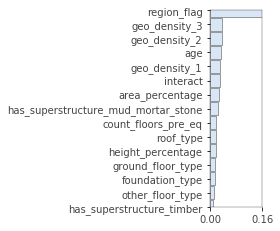

In [62]:
imp = importances(model3, X3, y) # permutation
viz = plot_importances(imp)
viz.view()

In [63]:
# still too dependent upon region flag imos

In [64]:
test_v = clean3(test)

In [65]:
#submit(model3, test_v, 'alansub5')